In [1]:
import numpy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()

# For reproducibility
torch.manual_seed(SEED)
device = torch.device("cuda" if cuda else "cpu")

if cuda:
    torch.cuda.manual_seed(SEED)

In [2]:
!git clone https://github.com/tcotte/CNN_Pytorch

Cloning into 'CNN_Pytorch'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 39 (delta 3), reused 39 (delta 3), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [7]:
%cd CNN_Pytorch/

/content/CNN_Pytorch


In [3]:
NetTransform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))                               
])

In [4]:
class_names = range(10)

In [36]:
from models.lenet_arch import Model_Type_LeNet
    
model_lenet = Model_Type_LeNet() # model type LeNet is not good for this applciation. Maybe it's because of the dimensions of the input picture or the MaxPool2d instead of the MeanPool2D

model_lenet.to(device)
# use an optim.Adam() optimizer
optimizer = optim.Adam(model_lenet.parameters(),  lr=0.001)

In [9]:
BATCH_SIZE=256

train_loader = dataloader.DataLoader(
    MNIST('./data', train=True, download=True, transform=NetTransform), 
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)

test_loader = dataloader.DataLoader(
    MNIST('./data', train=False, download=True, transform=NetTransform), 
    batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)



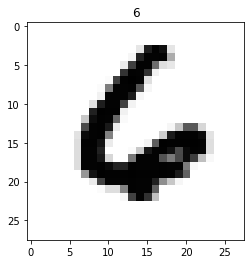

In [10]:
import torchvision
from functions.plot_picture import matplotlib_imshow
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# creat grid of images
img_grid = torchvision.utils.make_grid(images[0])

# show images & labels
matplotlib_imshow(img_grid, class_names[labels[0]])
# print()

In [37]:
from functions.training import train_model, evaluate_model

losses = []
accuracies = []
EPOCHS = 10
batch_size = 256
nb_batch = int(np.ceil(len(train_loader.dataset)/batch_size))

for epoch in range(EPOCHS):
  losses.extend(train_model(train_loader, device, model_lenet, optimizer, epoch, EPOCHS, batch_size)[-nb_batch:])
  accuracies.append(evaluate_model(model_lenet, device, test_loader, losses[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))

/content/CNN_Pytorch/models/lenet_arch.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = nn.functional.log_softmax(out, _stacklevel=3)


 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 0.151720	 Test Accuracy: 97.8500%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.059350	 Test Accuracy: 98.1000%
 Train Epoch: 3/10 [60000/60000 (100%)]	Loss: 0.065072	 Test Accuracy: 98.7000%
 Train Epoch: 4/10 [60000/60000 (100%)]	Loss: 0.297859	 Test Accuracy: 98.7400%
 Train Epoch: 5/10 [60000/60000 (100%)]	Loss: 0.019658	 Test Accuracy: 98.7800%
 Train Epoch: 6/10 [60000/60000 (100%)]	Loss: 0.029034	 Test Accuracy: 98.9100%
 Train Epoch: 7/10 [60000/60000 (100%)]	Loss: 0.006005	 Test Accuracy: 98.4700%
 Train Epoch: 8/10 [60000/60000 (100%)]	Loss: 0.031069	 Test Accuracy: 98.4800%
 Train Epoch: 9/10 [60000/60000 (100%)]	Loss: 0.031369	 Test Accuracy: 98.4500%
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.047138	 Test Accuracy: 98.7800%


Text(0.5, 1.0, 'Training loss during learning')

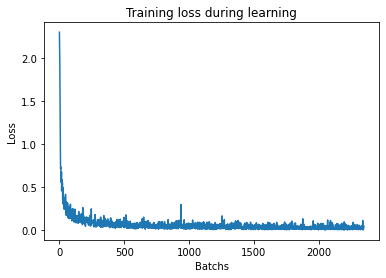

In [38]:
plt.plot(losses)
plt.xlabel("Batchs")
plt.ylabel("Loss")
plt.title("Training loss during learning")
# plt.ylim(0,3)

In [ ]:
from functions.plot_model import *

model = model_lenet

print(model.modules())
for m in model.modules():
    if isinstance(m, nn.Conv2d):
        # find the weight tensor for each module...
        plot_kernels(m.weight.data.cpu().numpy()) # .data.cpu().numpy() -> transfer data from gpu to cpu to use kernel


In [ ]:
layers = []
for n, p in model.named_parameters():
    if(p.requires_grad) and ("bias" not in n):
        layers.append(n)
fig = plt.figure(figsize=(8,8))
ax = fig.subplots()
plt.xlabel("mini batch")
plt.ylabel("Average Gradient")
plt.title("Gradient Flow")
plt.grid(True)

plot_grad_flow(model.named_parameters())

### Variation of learning rate

In [ ]:
from functions.training import train_model, evaluate_model

losses = []
accuracies = []
EPOCHS = 10
batch_size = 256
nb_batch = int(np.ceil(len(train_loader.dataset)/batch_size))

learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

for lr in learning_rates:
  print("<============== Learning Rate : "+ str(lr) +"==============>")
  optimizer = optim.Adam(model_lenet.parameters(),  lr=lr)
  for epoch in range(EPOCHS):
    losses.extend(train_model(train_loader, device, model_lenet, optimizer, epoch, EPOCHS, batch_size)[-nb_batch:])
    accuracies.append(evaluate_model(model_lenet, device, test_loader, losses[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))

In [ ]:
fig = plt.figure()
x = np.arange(10)

cnt = 0
fig = plt.figure(figsize=(12, 8))
for lr in learning_rates:
  plt.plot(x, accuracies[cnt*10:(cnt+1)*10], label=str(lr))
  cnt+=1

plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy in function of learning rate")

<generator object Module.modules at 0x7f79993ef6d0>


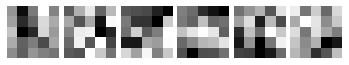

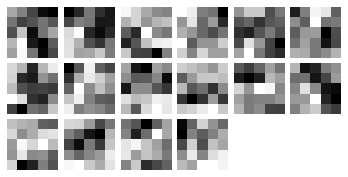

In [39]:
fig = plt.figure()
x = np.arange(10)

cnt = 0
fig = plt.figure(figsize=(12, 8))
for lr in learning_rates:
  plt.plot(x, accuracies[cnt*10:(cnt+1)*10], label=str(lr))
  cnt+=1

plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy in function of learning rate")

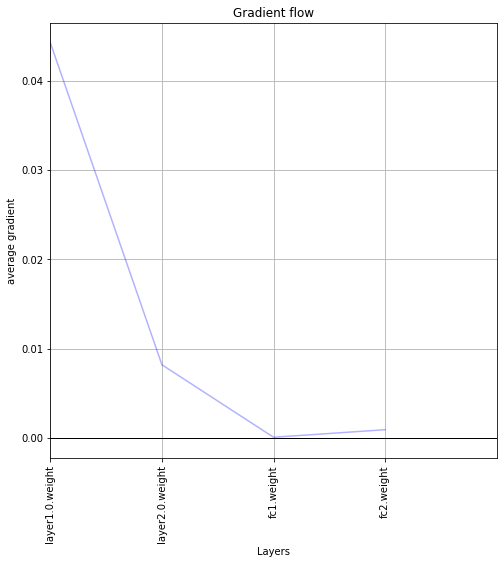

In [40]:
layers = []
for n, p in model.named_parameters():
    if(p.requires_grad) and ("bias" not in n):
        layers.append(n)
fig = plt.figure(figsize=(8,8))
ax = fig.subplots()
plt.xlabel("mini batch")
plt.ylabel("Average Gradient")
plt.title("Gradient Flow")
plt.grid(True)

plot_grad_flow(model.named_parameters())

### Variation of learning rate

In [41]:
from functions.training import train_model, evaluate_model

losses = []
accuracies = []
EPOCHS = 10
batch_size = 256
nb_batch = int(np.ceil(len(train_loader.dataset)/batch_size))

learning_rates = [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1]

for lr in learning_rates:
  print("<============== Learning Rate : "+ str(lr) +"==============>")
  optimizer = optim.Adam(model_lenet.parameters(),  lr=lr)
  for epoch in range(EPOCHS):
    losses.extend(train_model(train_loader, device, model_lenet, optimizer, epoch, EPOCHS, batch_size)[-nb_batch:])
    accuracies.append(evaluate_model(model_lenet, device, test_loader, losses[-1], EPOCHS, epoch, batch_size, len(train_loader.dataset)))

<============== Learning Rate : 0.0001==============>


/content/CNN_Pytorch/models/lenet_arch.py:64: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  sm = nn.functional.log_softmax(out, _stacklevel=3)


 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 0.004240	 Test Accuracy: 99.2200%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.001953	 Test Accuracy: 99.2300%
 Train Epoch: 3/10 [60000/60000 (100%)]	Loss: 0.000758	 Test Accuracy: 99.2000%
 Train Epoch: 4/10 [60000/60000 (100%)]	Loss: 0.000069	 Test Accuracy: 99.2700%
 Train Epoch: 5/10 [60000/60000 (100%)]	Loss: 0.001277	 Test Accuracy: 99.2200%
 Train Epoch: 6/10 [60000/60000 (100%)]	Loss: 0.001800	 Test Accuracy: 99.2200%
 Train Epoch: 7/10 [60000/60000 (100%)]	Loss: 0.002267	 Test Accuracy: 99.2400%
 Train Epoch: 8/10 [60000/60000 (100%)]	Loss: 0.000516	 Test Accuracy: 99.2300%
 Train Epoch: 9/10 [60000/60000 (100%)]	Loss: 0.006601	 Test Accuracy: 99.1500%
 Train Epoch: 10/10 [60000/60000 (100%)]	Loss: 0.013571	 Test Accuracy: 99.1800%
<============== Learning Rate : 0.0003==============>
 Train Epoch: 1/10 [60000/60000 (100%)]	Loss: 0.002260	 Test Accuracy: 99.1300%
 Train Epoch: 2/10 [60000/60000 (100%)]	Loss: 0.001278	 Test Accu

Text(0.5, 1.0, 'Accuracy in function of learning rate')

<Figure size 432x288 with 0 Axes>

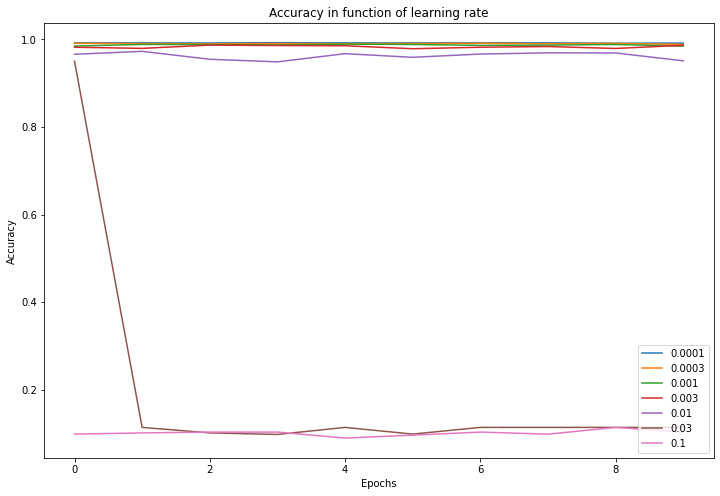

In [42]:
fig = plt.figure()
x = np.arange(10)

cnt = 0
fig = plt.figure(figsize=(12, 8))
for lr in learning_rates:
  plt.plot(x, accuracies[cnt*10:(cnt+1)*10], label=str(lr))
  cnt+=1

plt.legend(loc='lower right')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy in function of learning rate")